# Drugs experience analytics from Erowid.org

In [13]:
pip install ntlk

ERROR: Could not find a version that satisfies the requirement ntlk (from versions: none)
ERROR: No matching distribution found for ntlk

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.6/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
import json
from bs4 import BeautifulSoup
from collections import defaultdict
import re
from tqdm import tqdm
import os
import random
from time import sleep
import numpy as np
import string
from nltk import word_tokenize
from nltk.stem import PorterStemmer
import dateutil.parser

base_url = "https://www.erowid.org/"
json_file = 'erowid.json'

def take_text(header):
    return ' '.join(header.text.split())

def take_link(header):
    href = header.find('a', href=True)
    return href.text, href['href']

def remove_trailing_bracket(text):
    if text[-1].endswith(')'):
        text[-1] = text[-1][:-1]
    return text

def exp_links_page(drug):
    html = requests.get(base_url + 'experiences/' + drug['link']).text
    soup = BeautifulSoup(html, 'html.parser')
    more_pages = "&ShowViews=0&Cellar=0&Start=0&Max=10000"
    url = [base_url + a['href'] + more_pages for a in soup.find_all('a', href=True) 
     if 'exp.cgi?S1=' in a['href']]
    return url[0]

# def exp_links_page(drug):
#     try:
#         html = requests.get(base_url + 'experiences/' + drug['link']).text
#         soup = BeautifulSoup(html, 'html.parser')
#         more_pages = "&ShowViews=0&Cellar=0&Start=0&Max=10000"
#         url = [base_url + a['href'] + more_pages for a in soup.find_all('a', href=True) 
#             if 'exp.cgi?S1=' in a['href']]
#         if url:  # Check if the list is not empty
#             return url[0]
#         else:
#             print(f"No 'Show All' link found for {drug['name']}")
#             return None  # Return None if the link is not found
#     except Exception as e:
#         print(f"An error occurred while processing {drug['name']}: {e}")
#         return None  # Return None if any other error occurs

def exp_links(drug):
    url = exp_links_page(drug)
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html.parser')
    return [a['href'] for a in soup.find_all('a', href=True) if 'exp.php?ID=' in a['href']]

def save_page(ID, wait=True):
    fname = 'erowid-exps/' + ID.split('=')[-1]
    print(f"saving page with page ID: {ID}")
    if not os.path.exists(fname):
        url = base_url + 'experiences/' + ID
        response = requests.get(url, stream=True)
        if wait:
            # Be a responsible citizen and respect 'robots.txt'.
            sleep(1)
        with open(fname, "wb") as handle:
            for data in tqdm(response.iter_content()):
                handle.write(data)
        
def open_page(ID):
    fname = ID.split('=')[-1]
    with open(fname, "rb") as f:
        soup = BeautifulSoup(f, 'html.parser')
    return soup

def soup_from_file(ID):
    with open('erowid-exps/' + ID.split('=')[-1], 'rb') as f:
        soup = BeautifulSoup(f, 'html.parser')
    return soup

# Load or download data from Erowid

In [ ]:
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        drugs = json.load(f)
else:
    html = requests.get(base_url + "experiences/exp_list.shtml").text
    soup = BeautifulSoup(html, 'html.parser')
    headers = soup.find_all('td', {'bgcolor': '#002C00'})

    headers = [header for header in headers if not take_text(header)[0].startswith('[')]
    print("getting drugs...")
    drugs = defaultdict(dict)
    for header in headers:
        text = take_text(header)
        name, link = take_link(header)
        print(f"NAME: {name} | LINK: {link}")
        key = link.replace('.shtml', '').replace('subs/exp_', '')
        drugs[key]['name'] = name
        drugs[key]['link'] = link
        if ' - (see also ' in text:
            text = remove_trailing_bracket(text.split(' - (see also '))
            drugs[key]['see_also'] = text[1].split(', ')
        elif ' - (' in text:
            text = remove_trailing_bracket(text.split(' - ('))[1:]
            text = text[0].split(', see also ')
            drugs[key]['other'] = text[0].split(', ')
            if len(text) == 2:
                drugs[key]['see_also'] = text[1].split(', ')

    # for drug, data in drugs.items():
    #     print(f"DRUG: {drug} | DATA: {data}")
    #     exp_links_data = exp_links(data)
    #     data['exp_links'] = exp_links_data
    #     # print(f"DRUG: {drug} | EXP LINKS: {exp_links_data}")
    #     data['num_exp'] = len(data['exp_links'])

    for drug, data in drugs.items():
        print(f"DRUG: {drug} | DATA: {data}")     
        try:
            exp_links_data = exp_links(data)
            print("exp_links_data", exp_links_data)
            if exp_links_data:  # Only proceed if exp_links did not return None
                data['exp_links'] = exp_links_data
                data['num_exp'] = len(data['exp_links'])
                
                        # Here we just print the error and continue with the next ID
        except Exception as e:
            print(f"An error occurred while processing drug {drug}: {e}") 
            data['exp_links'] = None
    with open(json_file, 'w') as f:
        json.dump(drugs, f, sort_keys=True, indent=4)
print("GETTING IDS")
# IDs = [(name, ID) for name, drug in drugs.items() for ID in drug['exp_links'] if drug['num_exp'] > 150]
IDs = [(name, ID) for name, drug in drugs.items() if 'exp_links' in drug and drug['exp_links'] for ID in drug['exp_links'] if drug['num_exp'] > 150]
# drug_items = drugs.items()
# IDs = [(name, ID) for name, drug in drug_items[:10] if 'exp_links' in drug and drug['exp_links'] for ID in drug['exp_links'] if drug['num_exp'] > 150]

print("IDS", IDs)
random.shuffle(IDs)
first_ten_IDs = IDs[:10]
for name, ID in first_ten_IDs:
    try:
        save_page(ID)
    except:
        pass

soups = [(name, soup_from_file(ID)) for name, ID in first_ten_IDs[:3000]]


In [ ]:
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        drugs = json.load(f)
else:
    html = requests.get(base_url + "experiences/exp_list.shtml").text
    soup = BeautifulSoup(html, 'html.parser')
    headers = soup.find_all('td', {'bgcolor': '#002C00'})

    headers = [header for header in headers if not take_text(header)[0].startswith('[')]
    print("getting drugs...")
    drugs = defaultdict(dict)
    for header in headers:
        text = take_text(header)
        name, link = take_link(header)
        print(f"NAME: {name} | LINK: {link}")
        key = link.replace('.shtml', '').replace('subs/exp_', '')
        drugs[key]['name'] = name
        drugs[key]['link'] = link
        if ' - (see also ' in text:
            text = remove_trailing_bracket(text.split(' - (see also '))
            drugs[key]['see_also'] = text[1].split(', ')
        elif ' - (' in text:
            text = remove_trailing_bracket(text.split(' - ('))[1:]
            text = text[0].split(', see also ')
            drugs[key]['other'] = text[0].split(', ')
            if len(text) == 2:
                drugs[key]['see_also'] = text[1].split(', ')

    # for drug, data in drugs.items():
    #     print(f"DRUG: {drug} | DATA: {data}")
    #     exp_links_data = exp_links(data)
    #     data['exp_links'] = exp_links_data
    #     # print(f"DRUG: {drug} | EXP LINKS: {exp_links_data}")
    #     data['num_exp'] = len(data['exp_links'])

    for drug, data in drugs.items():
        print(f"DRUG: {drug} | DATA: {data}")     
        try:
            exp_links_data = exp_links(data)
            print("exp_links_data", exp_links_data)
            if exp_links_data:  # Only proceed if exp_links did not return None
                data['exp_links'] = exp_links_data
                data['num_exp'] = len(data['exp_links'])
                
                        # Here we just print the error and continue with the next ID
        except Exception as e:
            print(f"An error occurred while processing drug {drug}: {e}") 
            data['exp_links'] = None
    with open(json_file, 'w') as f:
        json.dump(drugs, f, sort_keys=True, indent=4)
print("GETTING IDS")
# IDs = [(name, ID) for name, drug in drugs.items() for ID in drug['exp_links'] if drug['num_exp'] > 150]
IDs = [(name, ID) for name, drug in drugs.items() if 'exp_links' in drug and drug['exp_links'] for ID in drug['exp_links'] if drug['num_exp'] > 150]
# drug_items = drugs.items()
# IDs = [(name, ID) for name, drug in drug_items[:10] if 'exp_links' in drug and drug['exp_links'] for ID in drug['exp_links'] if drug['num_exp'] > 150]

print("IDS", IDs)
random.shuffle(IDs)
first_ten_IDs = IDs[:10]
for name, ID in first_ten_IDs:
    try:
        save_page(ID)
    except:
        pass

soups = [(name, soup_from_file(ID)) for name, ID in first_ten_IDs[:3000]]


# What did we just download?

In [ ]:
top_drugs = sorted([(drug, data['num_exp']) for drug, data in drugs.items()],
                   key=lambda name: name[1], reverse=True)[:20]

print('The top {}:'.format(len(top_drugs)))
for drug, num in top_drugs:
    print('{} experiences for {}'.format(num, drug))

# Process the downloaded experiences

In [17]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaeldaigler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaeldaigler/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
def try_or_none(f):
    def new_f(x):
        try: return f(x)
        except: return None
    return new_f

def find_text_in_td(soup, text):
    td = soup.find('td', text=re.compile(text))
    try: return td.text.split(": ")[-1]
    except: return None

def find_class_attr(soup, name, class_attr=None):
    tds = soup.find_all(name, class_attr)
    try: return [td.text for td in tds]
    except: return None
    
def exp_year(soup):
    try:
        return soup.find('td', text=re.compile('Exp Year')).text.split(': ')[-1]
    except:
        return None
    
def get_text(soup):
    text_parts = soup.find('div', 'report-text-surround').get_text().split('\n\n\n\n\n')
    text_body = max(text_parts, key=len)
    return text_body.replace('\n', '').replace('\t', '')

def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    translator = str.maketrans({key: None for key in string.punctuation})
    text = text.translate(translator)
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens

def get_content(soup):
    content = {
        'ID': find_text_in_td(soup, 'ExpID'),
        'title': find_class_attr(soup, 'div', 'title'),
        'substance': find_class_attr(soup, 'div', 'substance'),
        'substances': find_class_attr(soup, 'td', 'dosechart-substance'),
        'method': find_class_attr(soup, 'td', 'dosechart-method'),
        'amount': find_class_attr(soup, 'td', 'dosechart-amount'),
        'form': find_class_attr(soup, 'td', 'dosechart-form'),
        'body_weight': find_class_attr(soup, 'td', 'bodyweight-amount'),
        'exp_year': exp_year(soup),
        'age': find_text_in_td(soup, 'Age at time of experience'),
        'sex': find_text_in_td(soup, 'Gender'),
        'published': try_or_none(dateutil.parser.parse)(find_text_in_td(soup, 'Published')),
        'text': try_or_none(get_text)(soup)}
    
    return content

contents = defaultdict(list)
for name, soup in soups:
    if len(contents[name]) < 51:
        content = get_content(soup)
        if content['text']:
            contents[name].append(content)

# Prepare train and test data

In [8]:
from sklearn.cross_validation import train_test_split

texts = [(name, item['text']) for name, drug in contents.items() for item in drug]
X = [text for substance, text in texts]
y = np.reshape([substance for substance, text in texts], (-1,))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Interactively print some texts to explore

In [26]:
from ipywidgets import interact

@interact(i=(0, len(texts)-1))
def text(i):
    print(texts[i])

('Opioids', "Greetings to all users of mind altering substances. I feel that I need to write a yet another cautionary tale concerning opiates. I would like to open with the fact that I believe opiates are of great theraputic use when used responsibly and properly. I also have come to see how incredibly easily they can become the devil's temptation. I have been using all types of drugs since I was 15 including pot, shrooms, cocaine, benzos, prescription sleep aids, barbituates, and finally opiates. I am now 21 and now four days sober out of a four day hospital detox using suboxone (buphenophrine) which I see as a miracle detox drug but I will get into that later.I began my dance with opiates at age 17. I was able to get my hands on some 5/500 (oxycodone/tylenol) percocets. I would sniff them one quarter at a time and they would bring me into a state of pleasure and apathy as if I was wrapped in the world's most comfortable blanket. It's effects, at least on me personally, are a warm fee

#  Document classification

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

# Train and create model
count_vect = CountVectorizer(ngram_range=(1, 2))
X_train_counts = count_vect.fit_transform(X_train)
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
clf = LinearSVC().fit(X_train_tf, y_train)

# Test
X_new_counts = count_vect.transform(X_test)
X_new_tfidf = tf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

np.mean(predicted == y_test)

0.50626566416040097

# Clustering of words

In [20]:
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
                             tokenizer=process_text,
                             stop_words=stopwords.words('english'),
                             max_df=0.5,
                             min_df=0.1,
                             lowercase=True,
                             ngram_range=(1, 2))

tfidf_model = vectorizer.fit_transform(X_train)
km_model = KMeans(n_clusters=5)
km_model.fit(tfidf_model)

clustering = defaultdict(list)

for idx, label in enumerate(km_model.labels_):
    clustering[label].append(idx)

In [21]:
order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i, _ in enumerate(clustering):
    print ("Cluster {}:".format(i))
    for ind in order_centroids[i, :10]:
        print( " %s" % terms[ind])

Cluster 0:
 dream
 sleep
 wake
 asleep
 rememb
 woke
 bed
 pill
 mg
 smoke
Cluster 1:
 dose
 high
 mg
 smoke
 combin
 quit
 ha
 substanc
 mix
 last
Cluster 2:
 hi
 walk
 talk
 room
 hous
 rememb
 said
 us
 told
 smoke
Cluster 3:
 pill
 im
 year
 didnt
 addict
 pain
 dont
 ive
 high
 month
Cluster 4:
 visual
 eye
 music
 everyth
 point
 intens
 mind
 im
 room
 dose


# Word Cloud

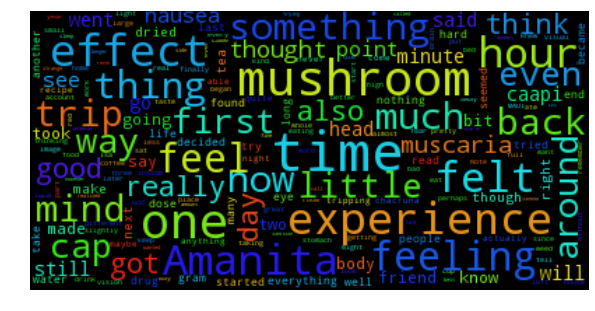

In [22]:
%matplotlib inline
from ipywidgets import interact
from wordcloud import WordCloud
import matplotlib.pyplot as plt

joined = [' '.join([text['text'] for text in drug]) for drug in contents.values() if len(drug)]

@interact(i=(0, len(joined) - 1))
def word_cloud(i):
    text = joined[i]
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
    plt.figure(figsize=(10,10), dpi=200)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()